In [1]:
import pandas as pd
from news_paper_dao import NewsPaperDao
from IPython.core.display import HTML
from os import getcwd
from news_paper_nlp_pre_processing import *
from nltk.corpus import stopwords
import nltk

In [2]:
# Récupère le répertoire du programme
curent_path = getcwd()+ "\\"
if "ema_lannuontimes" not in curent_path:
    curent_path += "PROJETS\\ema_lannuontimes\\"
print(curent_path)

c:\Users\User\WORK\workspace-ia\PROJETS\ema_lannuontimes\


<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Exploration des données: 
</div>

In [3]:
verbose = 1

dao = NewsPaperDao(nom_bdd=curent_path+"em_bdd.db")
assert dao.test_connexion()

df_articles = dao.get_articles(verbose=0)
print(df_articles.shape)

La version de SQLite est:  [('3.35.5',)]
(1867, 7)


In [4]:
color_by_journal = {"Le Trégor":"green","ActuGaming":"orange", "Elle":"pink", "30 M. d\\'amis":"blue"}
journaux = df_articles["journal"].unique()

In [5]:
print(df_articles.shape)
print(df_articles.columns)
display(HTML(df_articles.head().to_html()))

(1867, 7)
Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url'], dtype='object')


,titre,date_parution,journal,auteur,tags,texte,url
0,Lannion. Un cycliste renversé par une voiture en centre-ville,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la Poste à Lannion, en plein centre-ville, sur les quais, un cycliste a été renversé par une voiture. Légèrement blessé Le jeune cycliste, âgé de seize ans, a été légèrement blessé. Pompiers et policiers se sont rapidement rendus sur place. Le jeune homme a été pris en charge par les pompiers et transporté au centre hospitalier de Lannion.",https://actu.fr/bretagne/lannion_22113/lannion-un-cycliste-renverse-par-une-voiture-en-centre-ville_49325798.html
1,Perros-Guirec. Panne électrique : la mairie invite les citoyens à économiser l\'énergie,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,"Suite à la panne d’électricité géante sur la côte de Granit rose, ce week-end, de nombreuses coupures sont encore attendues jour et nuit. Les difficultés de réparation du poste de Saint-Quay-Perros vont encore durer un moment. Pas d’éclairage public Pour faire face, la mairie de Perros-Guirec va dès ce mardi soir 8 mars couper l’éclairage public. Nous avons 80 postes de répartition de l’éclairage public que nous allons couper, peut-être pas tout ce soir, mais dans les jours suivants. C’est une mesure d’économie pour ne pas trop tirer sur les installations précaires mises en place en attendant la réparation définitive. Economiser l’électricité Cette mesure publique s’accompagne aussi d’encouragements envers la population. Nous allons demander aux Perrosiens d’être vigilants sur leur consommation électrique le temps des réparations. Les élus confirment aussi les difficultés d’approvisionnement en gasoil des 124 groupes électrogènes installés dans les différentes communes de la côte de Granit rose. Les activités nautiques interdites Autre conséquence, les difficultés de fonctionnement des stations d’épuration. Les postes de relevage et de traitement ne fonctionnent pas normalement. La ville craint des débordements qui pourraient atteindre les plages. « Ce n’est pas encore le cas mais il y a des risques », explique Erven Léon. C’est pourquoi la mairie de Perros-Guirec a pris un arrêté interdisant les baignades et les activités nautiques sur les plages de Trestraou, Trestrignel et Saint-Guirec le temps d’un retour à la normale.",https://actu.fr/bretagne/perros-guirec_22168/perros-guirec-panne-electrique-la-mairie-invite-les-citoyens-a-economiser-lenergie_49242304.html
2,Louannec. Un gang de l\'Est avait pillé le distributeur de billets : 5 interpellations,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Rennes, Toulouse et le groupe de cybercriminalité de la gendarmerie ont pu interpeller les membres d’un groupe qui piratait les distributeurs il y a quelques jours. Liés à la criminalité Les membres de ce groupe sont liés à la criminalité organisée des pays de l’Est. Ils avaient dérobé 50 000 euros à Louannec. 50 000 euros à Louannec Les faits remontent à la nuit du 9 au 10 novembre 2021. A l’agence postale de Louannec, les individus percent le distributeur automatique afin de le pirater en se connectant dessus à l’aide d’un ordinateur. Une pratique connue appelée Jackpotting Le groupe repart avec 50 000 euros. Les gendarmes de Perros-Guirec et Lannion, appuyés par ceux de Rennes, mènent l’enquête. Des points communs Parallèlement, à Auch et Toulouse, des faits similaires sont relevés. Les enquêteurs mettent en commun leurs recherches et y trouvent des points communs. Le 3 février dernier, dans le sud ouest, les gendarmes de Toulouse ont interpellé 5 individus. 22 piratages pour 300 000 euros Ils ont reconnu avoir piraté 22 distributeurs de billets dans toute la France pour un montant total de 300 000 euros dont 50 000 euros à Louannec. C’est une opération énorme qui a été montée et une organisation qui a été démantelée. L’enquête se poursuit toutefois pour d’autres faits. Certains 

In [6]:
import matplotlib.pyplot as plt

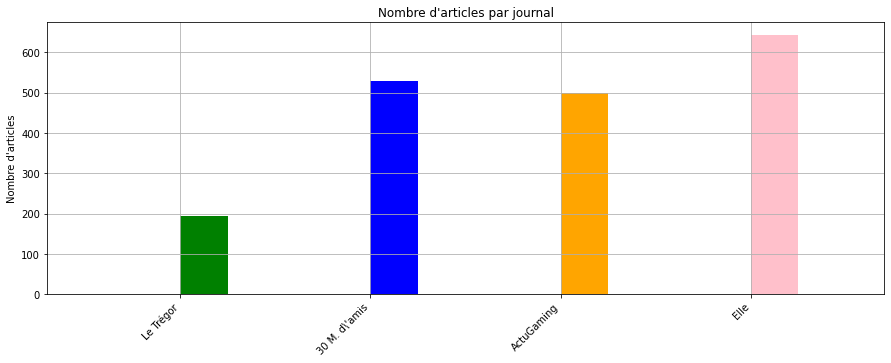

In [7]:
figure, axe = color_graph_background(1, 1)

bins = len(journaux)
for journal in journaux:
    df_articles[df_articles["journal"]==journal].journal.hist(ax=axe, color=color_by_journal.get(journal, "gray"), bins=bins)

figure.set_size_inches(15, 5, forward=True)
axe.set_ylabel("Nombre d'articles")
plt.title("Nombre d'articles par journal")
plt.xticks(rotation=45, ha="right")
plt.show()

In [8]:
df_articles = df_word_tokenize(df_articles, text_col_name='texte', token_col_name="mots_origine", verbose=verbose)

In [9]:
df_articles["nb_mots_origine"] = df_articles['texte'].apply(lambda x: word_count_func(x))

In [10]:
group = df_articles.groupby(["journal"], as_index=True).agg({'nb_mots_origine':['mean']})
group = group.reset_index()
group


,journal,nb_mots_origine
,,mean
0,30 M. d\'amis,1315.494340
1,ActuGaming,321.342000
2,Elle,387.481308
3,Le Trégor,305.943590


In [11]:
df_articles.columns

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine'],
      dtype='object')

In [12]:
list_tuple = [(i, i+299) for i in range (600, 3300, 300)]
list_tuple.insert(0, (200, 299))
list_tuple.insert(0, (100, 199))
list_tuple.insert(0, (0, 99))
list_tuple.append((3300, 100000))
bins = pd.IntervalIndex.from_tuples(list_tuple)
df_articles["tranche_nb_origin"] = pd.cut(df_articles['nb_mots_origine'], bins)
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69,"(0.0, 99.0]"
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233,"(200.0, 299.0]"
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228,"(200.0, 299.0]"
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236,"(200.0, 299.0]"
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422,NaN


In [13]:
group_nb_mots_art = df_articles.groupby(["journal", "tranche_nb_origin" ])["titre"].count().unstack("journal").fillna(0)
group_nb_mots_art.head()

journal,30 M. d\'amis,ActuGaming,Elle,Le Trégor
tranche_nb_origin,,,,
"(0, 99]",0,14,0,9
"(100, 199]",0,96,3,55
"(200, 299]",5,231,129,61
"(600, 899]",83,11,6,17
"(900, 1199]",97,11,10,0


In [14]:
from matplotlib.colors import ListedColormap

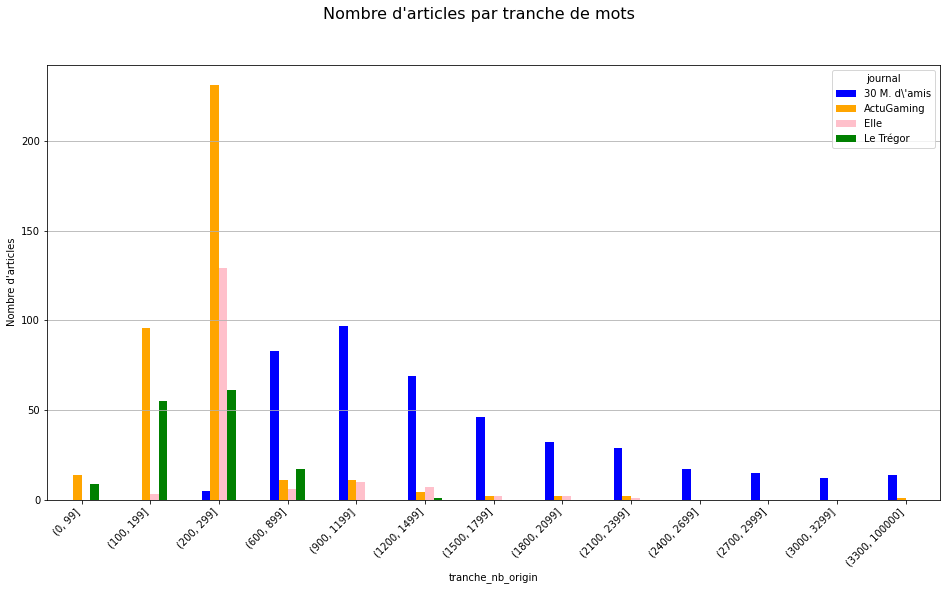

In [15]:
figure, axe = color_graph_background(1,1)

# On applique les mêmes couleurs que dans les autres graphes
my_cmap = ListedColormap(['blue', 'orange', 'pink', 'green'])

# Affichage d'articles par journal
group_nb_mots_art.plot(kind='bar', ax=axe, cmap=my_cmap)
axe.set_ylabel("Nombre d'articles")
axe.grid(axis='y')

figure.set_size_inches(16, 8, forward=True)
figure.suptitle("Nombre d'articles par tranche de mots", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.show()

In [16]:
df_articles.describe()

,nb_mots_origine
count,1867.000000
mean,624.694697
std,671.973323
min,60.000000
25%,274.000000
50%,357.000000
75%,670.000000
max,6930.000000


In [17]:
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin
0,Lannion. Un cycliste renversé par une voiture ...,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la P...",https://actu.fr/bretagne/lannion_22113/lannion...,"[jeudi, 10, mars, à, 16, h, 30, au, rond, poin...",69,"(0.0, 99.0]"
1,Perros-Guirec. Panne électrique : la mairie in...,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,Suite à la panne d’électricité géante sur la c...,https://actu.fr/bretagne/perros-guirec_22168/p...,"[suite, à, la, panne, d, électricité, géante, ...",233,"(200.0, 299.0]"
2,Louannec. Un gang de l\'Est avait pillé le dis...,11 Mar 22 à 20:08,Le Trégor,Christophe Ganne,faits-divers,"Les gendarmes de Perros-Guirec, Lannion, Renne...",https://actu.fr/bretagne/louannec_22134/louann...,"[les, gendarmes, de, perros, guirec, lannion, ...",228,"(200.0, 299.0]"
3,Lannion. Une conférence et une expo sur l’hydr...,9 Mar 22 à 12:25,Le Trégor,Rédaction Lannion,Actualité,L’association ArmorScience propose à l’IUT de ...,https://actu.fr/bretagne/lannion_22113/lannion...,"[l, association, armorscience, propose, à, l, ...",236,"(200.0, 299.0]"
4,Autour de Perros. Panne : des groupes électrog...,11 Mar 22 à 12:21,Le Trégor,Rédaction Lannion,societe,"Le village vacances de la CCAS, à Trébeurden, ...",https://actu.fr/bretagne/trebeurden_22343/auto...,"[le, village, vacances, de, la, ccas, à, trébe...",422,NaN


In [18]:
df_articles.columns

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine', 'tranche_nb_origin'],
      dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 3.NLP Preprocessing
</div>

In [19]:
personnal_stop_word = ["tout", "tous", "cette", "bien", "comme", "encore", "autre", "bien", "tres", "alors", "plus", "aussi", "si", "donc", "p", "h", "etre"]
if personnal_stop_word is None:
    personnal_stop_word = stopwords.words("french")
else :
    personnal_stop_word.extend(stopwords.words("french"))
len(personnal_stop_word)

174

In [20]:
def nlp_pre_process(input, sw=None, verbose=0):
    res = []
    res = tokenize(input)
    res = remove_stopwords_func(res, sw=sw)
    res = normalize_accented_chars(res)
    res = remove_irr_char_func(res)        
    res = remove_stopwords_func(res, sw=sw)
        
    res = list(filter(None, res))
    return res

In [21]:
df_articles["clean_words"] = df_articles['texte'].apply(lambda x: nlp_pre_process(x, sw=personnal_stop_word))
print(df_articles.columns)
display(HTML(df_articles.head().to_html()))

Index(['titre', 'date_parution', 'journal', 'auteur', 'tags', 'texte', 'url',
       'mots_origine', 'nb_mots_origine', 'tranche_nb_origin', 'clean_words'],
      dtype='object')


,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin,clean_words
0,Lannion. Un cycliste renversé par une voiture en centre-ville,10 Mar 22 à 17:05,Le Trégor,Christophe Ganne,faits-divers,"Jeudi 10 mars à 16 h 30, au rond point de la Poste à Lannion, en plein centre-ville, sur les quais, un cycliste a été renversé par une voiture. Légèrement blessé Le jeune cycliste, âgé de seize ans, a été légèrement blessé. Pompiers et policiers se sont rapidement rendus sur place. Le jeune homme a été pris en charge par les pompiers et transporté au centre hospitalier de Lannion.",https://actu.fr/bretagne/lannion_22113/lannion-un-cycliste-renverse-par-une-voiture-en-centre-ville_49325798.html,"[jeudi, 10, mars, à, 16, h, 30, au, rond, point, de, la, poste, à, lannion, en, plein, centre, ville, sur, les, quais, un, cycliste, a, été, renversé, par, une, voiture, légèrement, blessé, le, jeune, cycliste, âgé, de, seize, ans, a, été, légèrement, blessé, pompiers, et, policiers, se, sont, rapidement, rendus, sur, place, le, jeune, homme, a, été, pris, en, charge, par, les, pompiers, et, transporté, au, centre, hospitalier, de, lannion]",69,"(0.0, 99.0]","[jeudi, mars, rond, point, poste, lannion, plein, centre, ville, quais, cycliste, a, renverse, voiture, legerement, blesse, jeune, cycliste, age, seize, ans, a, legerement, blesse, pompiers, policiers, rapidement, rendus, place, jeune, homme, a, pris, charge, pompiers, transporte, centre, hospitalier, lannion]"
1,Perros-Guirec. Panne électrique : la mairie invite les citoyens à économiser l\'énergie,8 Mar 22 à 10:33,Le Trégor,Christophe Ganne,societe,"Suite à la panne d’électricité géante sur la côte de Granit rose, ce week-end, de nombreuses coupures sont encore attendues jour et nuit. Les difficultés de réparation du poste de Saint-Quay-Perros vont encore durer un moment. Pas d’éclairage public Pour faire face, la mairie de Perros-Guirec va dès ce mardi soir 8 mars couper l’éclairage public. Nous avons 80 postes de répartition de l’éclairage public que nous allons couper, peut-être pas tout ce soir, mais dans les jours suivants. C’est une mesure d’économie pour ne pas trop tirer sur les installations précaires mises en place en attendant la réparation définitive. Economiser l’électricité Cette mesure publique s’accompagne aussi d’encouragements envers la population. Nous allons demander aux Perrosiens d’être vigilants sur leur consommation électrique le temps des réparations. Les élus confirment aussi les difficultés d’approvisionnement en gasoil des 124 groupes électrogènes installés dans les différentes communes de la côte de Granit rose. Les activités nautiques interdites Autre conséquence, les difficultés de fonctionnement des stations d’épuration. Les postes de relevage et de traitement ne fonctionnent pas normalement. La ville craint des débordements qui pourraient atteindre les plages. « Ce n’est pas encore le cas mais il y a des risques », explique Erven Léon. C’est pourquoi la mairie de Perros-Guirec a pris un arrêté interdisant les baignades et les activités nautiques sur les plages de Trestraou, Trestrignel et Saint-Guirec le temps d’un retour à la normale.",https://actu.fr/bretagne/perros-guirec_22168/perros-guirec-panne-electrique-la-mairie-invite-les-citoyens-a-economiser-lenergie_49242304.html,"[suite, à, la, panne, d, électricité, géante, sur, la, côte, de, granit, rose, ce, week, end, de, nombreuses, coupures, sont, encore, attendues, jour, et, nuit, les, difficultés, de, réparation, du, poste, de, saint, quay, perros, vont, encore, durer, un, moment, pas, d, éclairage, public, pour, faire, face, la, mairie, de, perros, guirec, va, dès, ce, mardi, soir, 8, mars, couper, l, éclairage, public, nous, avons, 80, postes, de, répartition, de, l, éclairage, public, que, nous, allons, couper, peut, être, pas, tout, ce, soir, mais, dans, les, jours, suivants, c, est, une, mesure, d, économie, pour, ne, pas, trop, tirer, sur, ...]",233,"(200.0,

<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.1.Analyse nb mots
</div>

In [22]:
df_articles["nb_mots_clean"] = df_articles['clean_words'].apply(lambda x: word_count_func(x))

In [23]:
df_articles["freq_name"] = df_articles["clean_words"].apply(lambda x: nltk.FreqDist(x))
df_articles["freq_unique_words"] = df_articles["freq_name"].apply(lambda x: len(x.keys()))

In [24]:
df_articles = df_articles.sort_values(by=["freq_unique_words"], ascending=False)

In [25]:
df_articles.head()

,titre,date_parution,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin,clean_words,nb_mots_clean,freq_name,freq_unique_words
913,Tous les MMO à venir en 2022 et au-delà,28 janvier 2022 à 16:40,ActuGaming,Jordan,gaming,"Mine de rien, l’année 2021 a été assez chargée...",https://www.actugaming.net/sorties-mmo-2022-46...,"[mine, de, rien, l, année, 2021, a, été, assez...",4229,"(3300, 100000]","[mine, rien, annee, a, assez, chargee, sorties...",2359,"{'mine': 1, 'rien': 4, 'annee': 22, 'a': 41, '...",1066
833,Assassin’s Creed Valhalla : L’Aube du Ragnarök...,9 mars 2022 à 12:01,ActuGaming,FloRizzo,gaming,Depuis le lancement de la nouvelle trilogie my...,https://www.actugaming.net/assassins-creed-val...,"[depuis, le, lancement, de, la, nouvelle, tril...",2201,"(2100, 2399]","[depuis, lancement, nouvelle, trilogie, mythol...",1202,"{'depuis': 5, 'lancement': 1, 'nouvelle': 3, '...",791
1765,Charlène de Monaco : du conte à la réalité,15 décembre 2021 à 11h35,Elle,Dorothée Werner,People,Il était une fois une princesse enfermée dans ...,https://www.elle.fr/People/La-vie-des-people/N...,"[il, était, une, fois, une, princesse, enfermé...",1916,"(1800, 2099]","[fois, princesse, enfermee, etrange, melancoli...",1026,"{'fois': 6, 'princesse': 8, 'enfermee': 1, 'et...",748
1112,Pourquoi on aimerait voir un reboot de Darksta...,6 février 2022 à 11:00,ActuGaming,Neomantis Dee,gaming,Fort des succès critiques et commerciaux de Dr...,https://www.actugaming.net/pourquoi-on-aimerai...,"[fort, des, succès, critiques, et, commerciaux...",2062,"(1800, 2099]","[fort, succes, critiques, commerciaux, dragon,...",1119,"{'fort': 1, 'succes': 2, 'critiques': 1, 'comm...",724
694,Pourquoi on aimerait un retour de la licence d...,20 mars 2022 à 11:00,ActuGaming,Nathan Champion,gaming,"Certains jeux vous marquent à vie, et pas touj...",https://www.actugaming.net/retour-de-blob-chro...,"[certains, jeux, vous, marquent, à, vie, et, p...",2212,"(2100, 2399]","[certains, jeux, marquent, vie, toujours, rais...",1151,"{'certains': 2, 'jeux': 9, 'marquent': 1, 'vie...",713


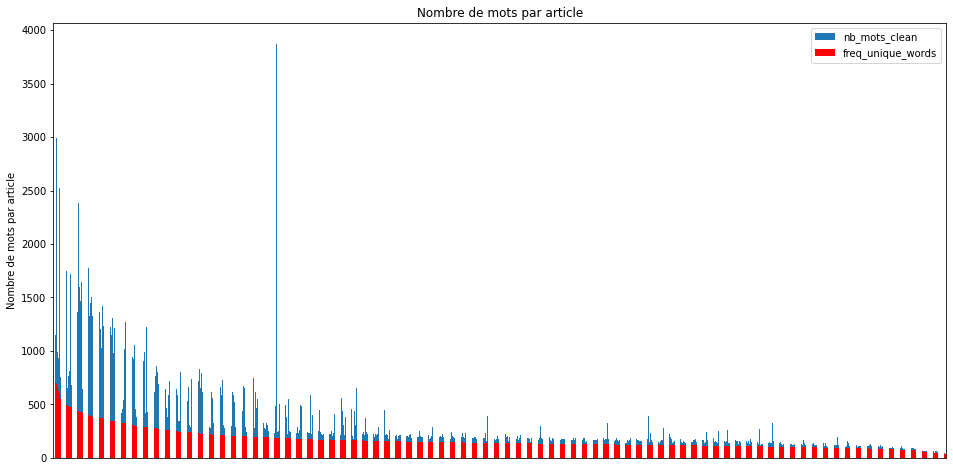

In [26]:
figure, axe = color_graph_background(1,1)

df_articles.plot(kind='bar', x='titre', y="nb_mots_clean", ax=axe, title='Nombre de mots par article')
df_articles.plot(y="freq_unique_words", x='titre', kind="bar", ax=axe, color="red")
figure.set_size_inches(16, 8, forward=True)

plt.ylabel("Nombre de mots par article")
plt.xlabel("")
plt.xticks([])
# plt.xticks(rotation=45, ha="right")
plt.show()

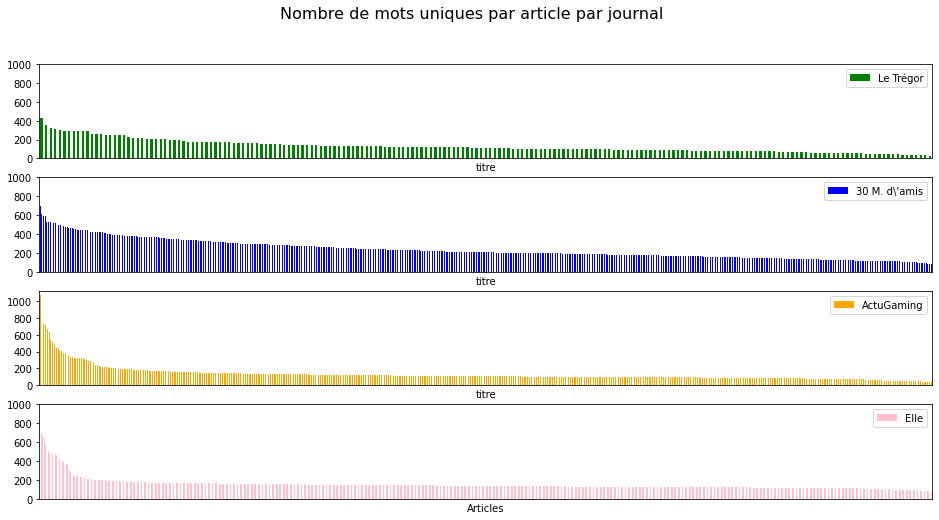

In [27]:
figure, axes = color_graph_background(len(journaux),1)

y_ticks = [i for i in range(0, 1200, 200)]

i = 0
for journal in journaux:
    df_articles[df_articles["journal"]==journal].plot(y="freq_unique_words", x='titre', label=journal, kind="bar", ax=axes[i], color=color_by_journal.get(journal, "gray"))
    axes[i].set_yticks(y_ticks)
    axes[i].set_xticks([])
    i += 1

figure.set_size_inches(16, 8, forward=True)
plt.suptitle('Nombre de mots uniques par article par journal', fontsize=16)
plt.xlabel("Articles")
plt.xticks([])
plt.show()

<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.2.Nuage de mots
</div>

In [28]:
from wordcloud import WordCloud

<div style="display: flex; background-color: indigo;" >

#### 3.2.1. SANS lemmatisation
</div>

In [29]:
df_articles["texte_clean"] = [','.join(map(str, l)) for l in df_articles["clean_words"]]
df_articles["sentence_clean"] = [' '.join(map(str, l)) for l in df_articles["clean_words"]]
df_articles["texte_clean"]

913     mine,rien,annee,a,assez,chargee,sorties,gros,m...
833     depuis,lancement,nouvelle,trilogie,mythologiqu...
1765    fois,princesse,enfermee,etrange,melancolie,pri...
1112    fort,succes,critiques,commerciaux,dragon,ball,...
694     certains,jeux,marquent,vie,toujours,raisons,fa...
                              ...                        
993     longtemps,repousse,rainbow,six,extraction,fina...
77      incendie,declare,tot,jeudi,mars,maison,habitat...
779     certains,peut,connu,epoque,windjammers,classiq...
54      policiers,intervenir,nuit,jeudi,vendredi,mars,...
0       jeudi,mars,rond,point,poste,lannion,plein,cent...
Name: texte_clean, Length: 1867, dtype: object

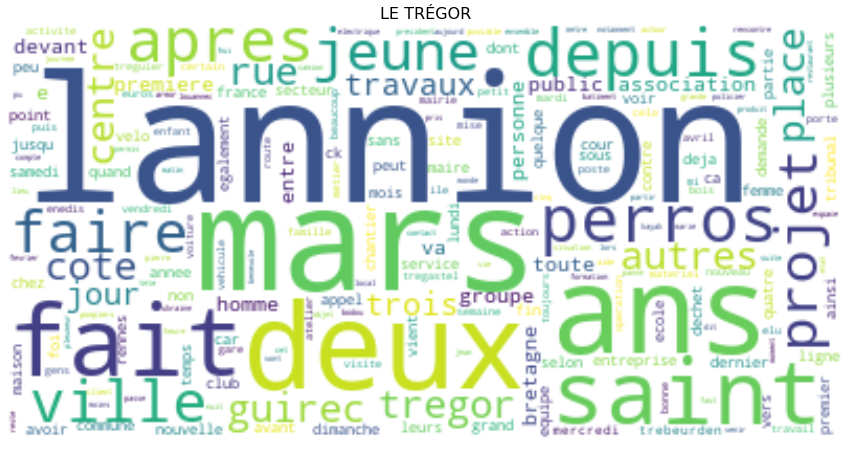

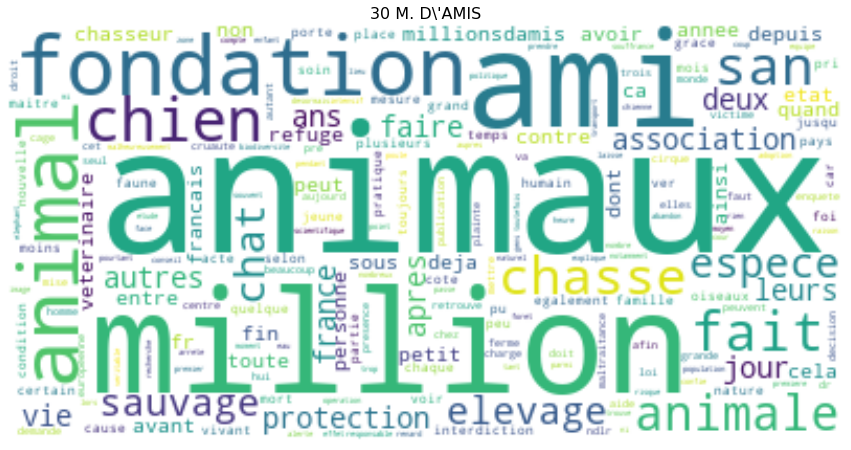

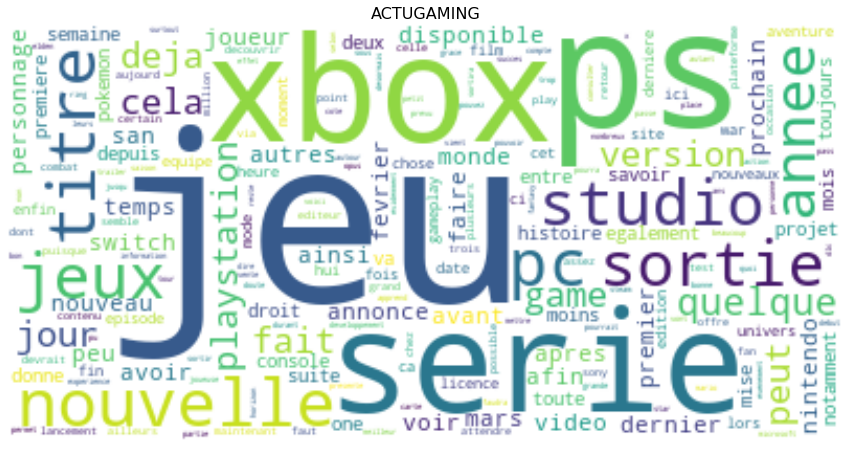

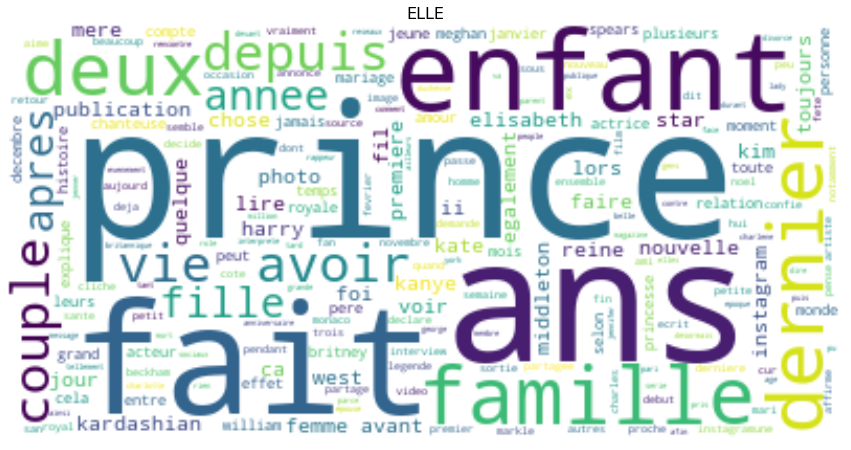

In [30]:
for journal in journaux:
    word_cloud(journal, df_articles)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 4.Entrainement d'un modèle de classification
</div>

Questions :
- Est-ce qu'on met en place l'approche td-idf ?
- Est-ce qu'on fait la lemmatisation ?
- 

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.0.Préparer les données
</div>

<div style="display: flex; background-color: indigo;" >

#### 4.0.1. Encodage de la target
</div>

In [31]:
from sklearn.preprocessing import LabelEncoder

In [32]:
random_state = 0

In [33]:
target_name = 'journal_code'
transformer_news_paper = LabelEncoder()
df_articles[target_name] = transformer_news_paper.fit_transform(df_articles["journal"])
#-- On positionne la colonne juste avant le nom du journal pour plus de lisibilité
cols = list(df_articles.columns)
cols.remove(target_name)
idx = cols.index('journal')
cols.insert(idx, target_name)
df_articles = df_articles[cols]
#--
df_articles

,titre,date_parution,journal_code,journal,auteur,tags,texte,url,mots_origine,nb_mots_origine,tranche_nb_origin,clean_words,nb_mots_clean,freq_name,freq_unique_words,texte_clean,sentence_clean
913,Tous les MMO à venir en 2022 et au-delà,28 janvier 2022 à 16:40,1,ActuGaming,Jordan,gaming,"Mine de rien, l’année 2021 a été assez chargée...",https://www.actugaming.net/sorties-mmo-2022-46...,"[mine, de, rien, l, année, 2021, a, été, assez...",4229,"(3300, 100000]","[mine, rien, annee, a, assez, chargee, sorties...",2359,"{'mine': 1, 'rien': 4, 'annee': 22, 'a': 41, '...",1066,"mine,rien,annee,a,assez,chargee,sorties,gros,m...",mine rien annee a assez chargee sorties gros m...
833,Assassin’s Creed Valhalla : L’Aube du Ragnarök...,9 mars 2022 à 12:01,1,ActuGaming,FloRizzo,gaming,Depuis le lancement de la nouvelle trilogie my...,https://www.actugaming.net/assassins-creed-val...,"[depuis, le, lancement, de, la, nouvelle, tril...",2201,"(2100, 2399]","[depuis, lancement, nouvelle, trilogie, mythol...",1202,"{'depuis': 5, 'lancement': 1, 'nouvelle': 3, '...",791,"depuis,lancement,nouvelle,trilogie,mythologiqu...",depuis lancement nouvelle trilogie mythologiqu...
1765,Charlène de Monaco : du conte à la réalité,15 décembre 2021 à 11h35,2,Elle,Dorothée Werner,People,Il était une fois une princesse enfermée dans ...,https://www.elle.fr/People/La-vie-des-people/N...,"[il, était, une, fois, une, princesse, enfermé...",1916,"(1800, 2099]","[fois, princesse, enfermee, etrange, melancoli...",1026,"{'fois': 6, 'princesse': 8, 'enfermee': 1, 'et...",748,"fois,princesse,enfermee,etrange,melancolie,pri...",fois princesse enfermee etrange melancolie pri...
1112,Pourquoi on aimerait voir un reboot de Darksta...,6 février 2022 à 11:00,1,ActuGaming,Neomantis Dee,gaming,Fort des succès critiques et commerciaux de Dr...,https://www.actugaming.net/pourquoi-on-aimerai...,"[fort, des, succès, critiques, et, commerciaux...",2062,"(1800, 2099]","[fort, succes, critiques, commerciaux, dragon,...",1119,"{'fort': 1, 'succes': 2, 'critiques': 1, 'comm...",724,"fort,succes,critiques,commerciaux,dragon,ball,...",fort succes critiques commerciaux dragon ball ...
694,Pourquoi on aimerait un retour de la licence d...,20 mars 2022 à 11:00,1,ActuGaming,Nathan Champion,gaming,"Certains jeux vous marquent à vie, et pas touj...",https://www.actugaming.net/retour-de-blob-chro...,"[certains, jeux, vous, marquent, à, vie, et, p...",2212,"(2100, 2399]","[certains, jeux, marquent, vie, toujours, rais...",1151,"{'certains': 2, 'jeux': 9, 'marquent': 1, 'vie...",713,"certains,jeux,marquent,vie,toujours,raisons,fa...",certains jeux marquent vie toujours raisons fa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,Rainbow Six Extraction : Un bon jeu coop dans ...,10 février 2022 à 11:36,1,ActuGaming,Julien,gaming,"Longtemps repoussé, Rainbow Six Extraction est...",https://www.actugaming.net/rainbow-six-extract...,"[longtemps, repoussé, rainbow, six, extraction...",60,"(0, 99]","[longtemps, repousse, rainbow, six, extraction...",41,"{'longtemps': 1, 'repousse': 1, 'rainbow': 3, ...",36,"longtemps,repousse,rainbow,six,extraction,fina...",longtemps repousse rainbow six extraction fina...
77,Trélévern. La chaudière met le feu au sous sol...,3 Mar 22 à 16:06,3,Le Trégor,Christophe Ganne,faits-divers,L’incendie s’est déclaré tôt ce jeudi 3 mars d...,https://actu.fr/bretagne/trelevern_22363/trele...,"[l, incendie, s, est, déclaré, tôt, ce, jeudi,...",71,"(0, 99]","[incendie, declare, tot, jeudi, mars, maison, ...",41,"{'incendie': 2, 'declare': 1, 'tot': 1, 'jeudi...",36,"incendie,declare,tot,jeudi,mars,maison,habitat...",incendie declare tot jeudi mars maison habitat...
779,Windjammers 2 : Que vaut le jeu de frisbee com...,8 février 2022 à 17:17,1,ActuGaming,Julien,gaming,Certains ne l’ont peut-être pas connu à l’époq...,https://www.actugaming.net/windjammers-2-que-v...,"[certains, ne, l, ont, peut, être, pas, connu,...",71,"(0, 99]","[certains, peut, connu, epo

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.1.Essaie avec TF-IDF
</div>

<div style="display: flex; background-color: indigo;" >

#### 4.0.2. Calcul
</div>

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
idf_full = df_articles.copy()

In [36]:
df_articles.columns

Index(['titre', 'date_parution', 'journal_code', 'journal', 'auteur', 'tags',
       'texte', 'url', 'mots_origine', 'nb_mots_origine', 'tranche_nb_origin',
       'clean_words', 'nb_mots_clean', 'freq_name', 'freq_unique_words',
       'texte_clean', 'sentence_clean'],
      dtype='object')

In [37]:
vectorizer_idf_big = TfidfVectorizer(analyzer="word",token_pattern=get_regex_tokens(), stop_words=personnal_stop_word, ngram_range = (1,1), max_features=400)
X = vectorizer_idf_big.fit_transform(idf_full['sentence_clean'])
idf_big_df = pd.DataFrame(X.toarray(), index=idf_full.index, columns=vectorizer_idf_big.get_feature_names_out())
# ajout du site web

# Réorganisation des colonnes pour la lecture
idf_full = pd.merge(idf_full, idf_big_df, left_index=True, right_index=True)
idf_full = idf_full.drop(["mots_origine", "url", "nb_mots_origine",'auteur', 'tags', 'nb_mots_clean','freq_name','freq_unique_words'], axis=1)
# --
idf_full.head()

,titre_x,date_parution,journal_code,journal,texte,tranche_nb_origin,clean_words,texte_clean,sentence_clean,a,...,ville,vivant,vivre,voir,vont,vraiment,vu,west,william,xbox
913,Tous les MMO à venir en 2022 et au-delà,28 janvier 2022 à 16:40,1,ActuGaming,"Mine de rien, l’année 2021 a été assez chargée...","(3300, 100000]","[mine, rien, annee, a, assez, chargee, sorties...","mine,rien,annee,a,assez,chargee,sorties,gros,m...",mine rien annee a assez chargee sorties gros m...,0.141865,...,0.023731,0.0,0.012134,0.029184,0.000000,0.039620,0.020364,0.0,0.0,0.043966
833,Assassin’s Creed Valhalla : L’Aube du Ragnarök...,9 mars 2022 à 12:01,1,ActuGaming,Depuis le lancement de la nouvelle trilogie my...,"(2100, 2399]","[depuis, lancement, nouvelle, trilogie, mythol...","depuis,lancement,nouvelle,trilogie,mythologiqu...",depuis lancement nouvelle trilogie mythologiqu...,0.125485,...,0.000000,0.0,0.000000,0.026460,0.000000,0.000000,0.000000,0.0,0.0,0.079724
1765,Charlène de Monaco : du conte à la réalité,15 décembre 2021 à 11h35,2,Elle,Il était une fois une princesse enfermée dans ...,"(1800, 2099]","[fois, princesse, enfermee, etrange, melancoli...","fois,princesse,enfermee,etrange,melancolie,pri...",fois princesse enfermee etrange melancolie pri...,0.225858,...,0.000000,0.0,0.000000,0.026458,0.000000,0.035919,0.000000,0.0,0.0,0.000000
1112,Pourquoi on aimerait voir un reboot de Darksta...,6 février 2022 à 11:00,1,ActuGaming,Fort des succès critiques et commerciaux de Dr...,"(1800, 2099]","[fort, succes, critiques, commerciaux, dragon,...","fort,succes,critiques,commerciaux,dragon,ball,...",fort succes critiques commerciaux dragon ball ...,0.129152,...,0.000000,0.0,0.000000,0.000000,0.041475,0.036971,0.076009,0.0,0.0,0.000000
694,Pourquoi on aimerait un retour de la licence d...,20 mars 2022 à 11:00,1,ActuGaming,"Certains jeux vous marquent à vie, et pas touj...","(2100, 2399]","[certains, jeux, marquent, vie, toujours, rais...","certains,jeux,marquent,vie,toujours,raisons,fa...",certains jeux marquent vie toujours raisons fa...,0.098163,...,0.134652,0.0,0.000000,0.041397,0.031523,0.056201,0.000000,0.0,0.0,0.031183


<div style="display: flex; background-color: indigo;" >

#### 4.0.3. Préparer le test et train
</div>

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
numeric_cols = get_numeric_columns_names(idf_full, verbose=verbose)
numeric_cols.remove(target_name)
numeric_cols

['a',
 'acte',
 'action',
 'actrice',
 'adoption',
 'affirme',
 'afin',
 'age',
 'agit',
 'aide',
 'ailleurs',
 'ainsi',
 'alerte',
 'amis',
 'amour',
 'an',
 'animal',
 'animale',
 'animaux',
 'annee',
 'annees',
 'annonce',
 'ans',
 'apres',
 'arrete',
 'arrivee',
 'assez',
 'association',
 'associations',
 'aucun',
 'aucune',
 'aujourd',
 'aupres',
 'autant',
 'autour',
 'autres',
 'avant',
 'avoir',
 'beaucoup',
 'besoin',
 'biodiversite',
 'bon',
 'bonne',
 'britney',
 'ca',
 'car',
 'cas',
 'cause',
 'cela',
 'celle',
 'celui',
 'centre',
 'certaines',
 'certains',
 'cet',
 'ceux',
 'chanteuse',
 'chaque',
 'charge',
 'chasse',
 'chasseurs',
 'chat',
 'chats',
 'chez',
 'chien',
 'chienne',
 'chiens',
 'chose',
 'choses',
 'ci',
 'cirques',
 'code',
 'comment',
 'compagnie',
 'compte',
 'conditions',
 'confie',
 'confirme',
 'contre',
 'cote',
 'cotes',
 'couple',
 'cours',
 'cruaute',
 'cur',
 'date',
 'debut',
 'decembre',
 'decide',
 'decision',
 'declare',
 'deja',
 'demande'

In [40]:
# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(idf_full[numeric_cols], idf_full[target_name], test_size=0.2, random_state=random_state)
print(f" Train : {X_train_idf.shape} et {y_train_idf.shape} --- Test : {X_test_idf.shape} et {y_test_idf.shape}")

 Train : (1493, 400) et (1493,) --- Test : (374, 400) et (374,)


<div style="display: flex; background-color: indigo;" >

#### 4.0.4. Prédiction
</div>

In [41]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC

In [42]:
verbose = 0

#Create classifier
model_list = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose), # SCORE de 0.643333
    "KNN":KNeighborsClassifier(n_neighbors=3), # SCRORE de 0.558333
    "LinearSVC":LinearSVC(random_state=random_state, verbose=verbose),
    "naiveGaussianNB":GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

# Train the model using the training sets
model_dic_idf, scores_idf = fit_and_test_models(model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, verbose=verbose)

score_all_class_df = pd.DataFrame(scores_idf).set_index("Modeli")
score_all_class_df.round(decimals=3)
score_all_class_df = score_all_class_df.sort_values(by="R2", ascending=False)
score_all_class_df

,Class,Model,R2,fit time,fit seconde
Modeli,,,,,
BernoulliNB,,BernoulliNB,0.997326,00:00:00,0.016034
LinearSVC,,LinearSVC,0.983957,00:00:00,0.020530
SVC,,SVC,0.981283,00:00:00,0.234729
LogisticR,,LogisticR,0.970588,00:00:00,0.104702
MultinomialNB,,MultinomialNB,0.970588,00:00:00,0.007420
naiveGaussianNB,,naiveGaussianNB,0.965241,00:00:00,0.022134
ComplementNB,,ComplementNB,0.957219,00:00:00,0.006074
KNN,,KNN,0.946524,00:00:00,0.024112


<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.2.Optimisation du modèle retenu
</div>

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
grid_params_BernoulliNB = { 'alpha' : [0,1],
                            'binarize' : [0.0, 0.5,1],
                            'fit_prior' : [True,False]
                            }

In [45]:
cross_validation = 3
grid_model_list = {
    "Grid_BernoulliNB":GridSearchCV(estimator=BernoulliNB(), param_grid=grid_params_BernoulliNB, cv=cross_validation, verbose=verbose),
}

In [46]:
# Train the model using the training sets
model_dic_idf_grid, scores_idf_grid = fit_and_test_models(grid_model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, scores=scores_idf, verbose=verbose)

score_grid_idf = pd.DataFrame(scores_idf_grid).set_index("Modeli")
score_grid_idf.round(decimals=3)
score_grid_idf = score_grid_idf.sort_values(by="R2", ascending=False)
score_grid_idf

,Class,Model,R2,fit time,fit seconde
Modeli,,,,,
BernoulliNB,,BernoulliNB,0.997326,00:00:00,0.016034
Grid_BernoulliNB,,Grid_BernoulliNB,0.997326,00:00:00,0.535447
LinearSVC,,LinearSVC,0.983957,00:00:00,0.020530
SVC,,SVC,0.981283,00:00:00,0.234729
LogisticR,,LogisticR,0.970588,00:00:00,0.104702
MultinomialNB,,MultinomialNB,0.970588,00:00:00,0.007420
naiveGaussianNB,,naiveGaussianNB,0.965241,00:00:00,0.022134
ComplementNB,,ComplementNB,0.957219,00:00:00,0.006074
KNN,,KNN,0.946524,00:00:00,0.024112


<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.3.Sauvegarde du modèle entrainé
</div>

In [47]:
model_path = save_model(model_dic_idf.get("BernoulliNB", None), curent_path)
model_path

'c:\\Users\\User\\WORK\\workspace-ia\\PROJETS\\ema_lannuontimes\\ema_lannuontimes_saved_model_2022-03-29-09_22_16.joblib'

In [48]:
import pickle

In [49]:
# Sauvegarde du vecteur TF-IDF
tf_idf_fil_name = curent_path+"tfidf.pickle"
pickle.dump(vectorizer_idf_big, open(tf_idf_fil_name, "wb"))

In [50]:
tf_idf_fil_name

'c:\\Users\\User\\WORK\\workspace-ia\\PROJETS\\ema_lannuontimes\\tfidf.pickle'

In [51]:
# Sauvegarde du label encoder
label_encoder_file_name = curent_path+"label_encoder.pickle"
pickle.dump(transformer_news_paper, open(label_encoder_file_name, "wb"))
label_encoder_file_name

'c:\\Users\\User\\WORK\\workspace-ia\\PROJETS\\ema_lannuontimes\\label_encoder.pickle'

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.4.Prédiction
</div>

In [52]:
from news_paper_loading import get_text_from_URL

In [53]:
url_30M = 'https://www.30millionsdamis.fr/actualites/article/22101-deux-lions-et-deux-tigres-ukrainiens-transferes-dans-un-refuge-aux-pays-bas/'
text_30M = get_text_from_URL(url_30M)
url_elle = 'https://www.elle.fr/People/La-vie-des-people/News/Miley-Cyrus-son-mariage-desastreux-avec-Liam-Hemsworth-4011676'
text_elle = get_text_from_URL(url_elle)
url_actu = 'https://www.actugaming.net/god-of-war-ragnarok-sortirait-toujours-en-2022-selon-santa-monica-studios-489652/'
text_actu = get_text_from_URL(url_actu)
url_tregor = 'https://actu.fr/bretagne/lannion_22113/lannion-sept-ukrainiens-accueillis-a-lhotel-ibis_49736570.html'
text_tregor = get_text_from_URL(url_tregor)

In [54]:
articles = {"text":[text_30M, text_elle, text_actu, text_tregor]}
df_to_predict = pd.DataFrame(articles)
df_to_predict

,text
0,Deux lions et deux tigres gravement traumatisé...
1,L’histoire d’amour entre Miley Cyrus et Liam H...
2,Avec les reports qui s’enchaînent depuis l’ann...
3,Trois familles d’Ukraine ont fui leur pays en ...


In [55]:
df_to_predict["clean_words"] = df_to_predict['text'].apply(lambda x: nlp_pre_process(x, sw=personnal_stop_word))
print(df_to_predict.columns)
display(HTML(df_to_predict.head().to_html()))

Index(['text', 'clean_words'], dtype='object')


,text,clean_words
0,"Deux lions et deux tigres gravement traumatisés et sous-alimentés ont été récupérés à la frontière entre l'Ukraine et la Pologne par l'organisation néerlandaise Stichting Leeuw qui les as transférés dans son refuge au nord des Pays-Bas. 30millionsdamis.fr revient sur ce sauvetage. Ils se nomment Dembe, Max, Radjah et Shanti... Deux lions, un jeune tigre et une tigresse ont été récupérés à la frontière ukrainienne par l'association ""Stichting Leeuw"" pour être mis en sécurité dans son refuge, à Anna Paulowna, au nord des Pays-Bas(19/03). Des animaux traumatisés et dénutris « Les animaux sont gravement traumatisés et sous-alimentés », déplore Robert Kruijff, le directeur de l'organisation. Les quatre rescapés pourraient ne pas avoir été nourris depuis une ou deux semaines. « Petit à petit, ils vont mieux, tente de rassurer l'association, sur Facebook. Mais la peur est toujours là ». Shanti, la tigresse serait la plus mal en point : il est encore trop tôt pour savoir si elle pourra survivre. Les animaux sont gravement traumatisés et sous-alimentés Petit à petit, ils vont mieux Mais la peur est toujours là Les quatre réfugiés doivent désormais rester un mois en quarantaine au refuge de l'organisation. Ils devront reprendre des forces - ce qui pourrait durer un ou deux ans - avant de pouvoir rejoindre leur destination finale : une réserve en Afrique du Sud. Un transfert dangereux Leur transfert a été organisé par le zoo de Poznan, situé dans l'ouest de la Pologne. Transportés dans un bus remplis d'animaux ukrainiens, les quatre fauves ont subi un voyage long et périlleux. Début mars, six lions, des tigres et d'autres félins évacués d'Ukraine ont également été accueillis dans des refuges pour animaux situés en Espagne et en Belgique – partenaires de la Fondation 30 Millions d'Amis – après un périlleux voyage en camion au cours duquel le véhicule s'est retrouvé face à des chars russes et a dû éviter les zones bombardées. des refuges pour animaux situés en Espagne et en Belgique (Avec AFP)","[deux, lions, deux, tigres, gravement, traumatises, sous, alimentes, recuperes, frontiere, entre, ukraine, pologne, organisation, neerlandaise, stichting, leeuw, transferes, refuge, nord, pays, bas, millionsdamis, fr, revient, sauvetage, nomment, dembe, max, radjah, shanti, deux, lions, jeune, tigre, tigresse, recuperes, frontiere, ukrainienne, association, stichting, leeuw, mis, securite, refuge, anna, paulowna, nord, pays, bas, animaux, traumatises, denutris, animaux, gravement, traumatises, sous, alimentes, deplore, robert, kruijff, directeur, organisation, quatre, rescapes, pourraient, avoir, nourris, depuis, deux, semaines, petit, petit, vont, mieux, tente, rassurer, association, facebook, peur, toujours, shanti, tigresse, mal, point, trop, tot, savoir, pourra, survivre, animaux, gravement, traumatises, sous, alimentes, petit, petit, vont, mieux, peur, ...]"
1,"L’histoire d’amour entre Miley Cyrus et Liam Hemsworth a connu de nombreux rebondissements. Après une rencontre en 2009, le couple s’est séparé puis remis ensemble à plusieurs reprises. Jusqu’au 23 décembre 2018, où Miley Cyrus et Liam Hemsworth finissent par se marier dans leur maison du Tennessee dans le plus grand des secrets. Mais huit mois plus tard, la chanteuse et l’acteur annoncent leur séparation définitive : « Juste un petit mot pour vous dire que Miley et moi venons de nous séparer et que je ne lui souhaite que la santé et le bonheur », écrivait alors Liam Hemsworth sur son compte Instagram. Un fiasco sur lequel Miley Cyrus est revenue alors qu’elle était sur la scène du festival Lollapalooza, à São Paulo, au Brésil. Lire aussi >> Couple de légende : Miley Cyrus et Liam Hemsworth, les trop jeunes amoureux« J’espère que ton mariage va mieux se passer que le mien » Selon le « Daily Mail », la chanteuse a fait monter sur scène un couple pour une demande en mariage. Après avoir félicité les futurs mariés, Miley Cyrus a ajouté : « Chéri, j’espère que ton mar

In [56]:
idf_to_predict = df_to_predict.copy()

In [57]:
idf_to_predict.columns

Index(['text', 'clean_words'], dtype='object')

In [58]:
idf_to_predict["texte_clean"] = [','.join(map(str, l)) for l in idf_to_predict["clean_words"]]
idf_to_predict["sentence_clean"] = [' '.join(map(str, l)) for l in idf_to_predict["clean_words"]]
idf_to_predict["texte_clean"]

0    deux,lions,deux,tigres,gravement,traumatises,s...
1    histoire,amour,entre,miley,cyrus,liam,hemswort...
2    reports,enchainent,depuis,annee,derniere,a,com...
3    trois,familles,ukraine,fui,pays,guerre,apres,p...
Name: texte_clean, dtype: object

In [59]:
loaded_model_tf_idf = pickle.load(open(tf_idf_fil_name, 'rb'))

In [60]:
label_encoder_file_name
loaded_label_encoder = pickle.load(open(label_encoder_file_name, 'rb'))

In [61]:
X_to_predict = loaded_model_tf_idf.transform(idf_to_predict['sentence_clean'])
idf_big_df_to_predic = pd.DataFrame(X_to_predict.toarray(), index=idf_to_predict.index, columns=vectorizer_idf_big.get_feature_names_out())

In [62]:
print(type(X_to_predict))
X_to_predict.shape

<class 'scipy.sparse._csr.csr_matrix'>


(4, 400)

In [63]:
idf_big_df_to_predic.head()

,a,acte,action,actrice,adoption,affirme,afin,age,agit,aide,...,ville,vivant,vivre,voir,vont,vraiment,vu,west,william,xbox
0,0.063946,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.205351,0.0,0.0,0.0,0.0,0.0
1,0.148330,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.164818,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.086884,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.108143,0.0,0.0,0.0,0.0,0.0,0.0,0.111956,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [64]:
def from_wich_news_paper(idf_big_df_to_predic, model, label_encoder, verbose=0):
    # Recherche du journal d'origine
    numeric_cols = get_numeric_columns_names(idf_big_df_to_predic)
    res = model.predict(idf_big_df_to_predic[numeric_cols])
    print (label_encoder.inverse_transform(res))
    return label_encoder.inverse_transform(res)

In [66]:
model_path = curent_path + "ema_lannuontimes_saved_model_2022-03-29-09_22_16.joblib"

In [67]:
# Chargement du modèle si non chargé
saved_model_titi = load_model(model_path)
from_wich_news_paper(idf_big_df_to_predic,model=saved_model_titi,label_encoder=loaded_label_encoder)


["30 M. d\\'amis" 'Elle' 'ActuGaming' 'Le Trégor']


array(["30 M. d\\'amis", 'Elle', 'ActuGaming', 'Le Trégor'], dtype=object)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## ANNEXE
</div>